## Lecture 7: Introduction to Convolutional Layers

The goal of this lab is to understand how to train a convolutional neural network using PyTorch.

The dataset we will analyze will be a small section of the nih chest xrays dataset, found here: https://www.kaggle.com/nih-chest-xrays/sample. The dataset has images of resolution 1024x1024, but to make it computationally easier we have first applied pooling in scipy to reduce the dimensionality to 64x64.


In [ ]:
#Import common dependencies
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
import datetime
import glob
import pickle
from pathlib import Path
from torch import nn
from torch.nn import init
from torch.autograd import Variable
from scipy import misc
import pdb

# First we address some of the in class activities.


In [ ]:
#Use python to generate the kernels randomly [-1, 0, 1] 
#and calculate the hidden layer values for the follow input image:
inpt = [[2, 1, 0, 0,1],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 2, 0],
        [1, 2, 0, 1, 0],
        [0, 1, 0, 0, 1]]

In [ ]:
input_kernel_output = {}
mat = np.array(inpt)
for i in range(1, 4):
    for j in range(1, 4):
        for k in range(2):
            inpt_x = mat[i-1:i+2, j-1:j+2]
            kernel = np.random.choice([-1, 0, 1], (3, 3))
            output = (inpt_x * kernel).sum()
            #apply relu
            output = output.clip(0, np.inf)
            input_kernel_output[(i, j, k)] = {'input ':inpt_x.tolist(), 'kernel':kernel.tolist(), 'output':output.tolist()}

from pprint import pprint
pprint(input_kernel_output)

In [ ]:
input_kernel_output_parameter_sharing = {}
mat = np.array(inpt)
np.random.seed(1)
for k in range(2):
    kernel = np.random.choice([-1, 0, 1], (3, 3))
    for i in range(1, 4):
        for j in range(1, 4):
            inpt_x = mat[i-1:i+2, j-1:j+2]
            
            output = (inpt_x * kernel).sum()
            #apply relu
            output = output.clip(0, np.inf)
            input_kernel_output_parameter_sharing[(i, j, k)] = {'input ':inpt_x.tolist(), 'kernel':kernel.tolist(), 'output':output.tolist()}

from pprint import pprint
pprint(input_kernel_output_parameter_sharing)

## Dataset Selection

### First, read in the sample labels which we will treat as y classes, and split into trn and val

In [ ]:
label_df = pd.read_csv('sample_labels.csv').iloc[:, [1]]
label_df.columns = ['label']
num_rows = label_df.shape[0]
val_frac = .9
samples = np.random.rand(num_rows)
cutoff = np.percentile(samples, val_frac * 100)
trn, val = samples < cutoff, samples >= cutoff

### Next, map labels to unique values, and drop all uncommon labels into a 'unknown' label

In [ ]:


uni_lbls = label_df['label'].value_counts().sort_values(ascending=False)
lbls = uni_lbls[uni_lbls > 100]
lbl_keys = lbls.keys()
num_keys = len(lbl_keys)
lbl_idx = np.arange(num_keys)

unk = 'unknown/uncommon'

lbl_map = {key:idx for key, idx in zip(lbl_keys, lbl_idx)}
inv_lbl_map = {idx:key for key, idx in zip(lbl_keys, lbl_idx)}

for lbl in label_df['label'].unique():
    if lbl not in lbl_map.keys():
        lbl_map[lbl] = num_keys
label_df['label_idx'] = label_df['label'].map(lbl_map)

trn_df = label_df.loc[trn]
val_df = label_df.loc[val]

### Load in the corresponding images, or load in the pre processed numpy array that we use to store them. Lets normalize them to [0,1]

In [ ]:
my_file = Path("images.pickle")
if not my_file.is_file():
    import skimage.measure

    images = np.empty((num_rows, 64, 64))
    for idx,filename in enumerate(glob.glob('images/*')): #assuming gif
        im=misc.imread(filename)
        if im.shape[-1] < 5:
            im = im[:,:,0]
        im = skimage.measure.block_reduce(im, (16,16), np.max)
        images[idx,:,:] = im

    images = np.reshape(images, [num_rows, 1, 64, 64])
    images = images - images.min()
    images = images/images.max()
    pickle.dump(images, open('images.pickle', 'wb'))
else:
    images = pickle.load(open('images.pickle','rb'))
trn_images = images[trn,:,:,:]
val_images = images[val,:,:,:]

### Lets just visualize an image to see what we're looking at

In [ ]:
plt.imshow(trn_images[0,0,:,:])
plt.show()

In [ ]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 1

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

In [ ]:
#Build the network in pytorch

def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    #Identity Module
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,input_shape, hidden_layers = None, num_outputs = 1, lr = 1e-3):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        nn.Module.__init__(self)
        self.input_shape = input_shape
        
        prev_filters = 1
        self.hidden_layers = nn.ModuleList()
        shape = input_shape
        self.trn_losses = []
        self.val_losses = []
        self.relu = nn.LeakyReLU()
        if hidden_layers is not None:
            for idx, (filters, kernel_size, stride, padding, pool) in enumerate(hidden_layers):
                if pool:
                    layer = nn.MaxPool2d(kernel_size, stride=stride, padding=padding)
                    self.hidden_layers.append(layer)
                else:
                    layer = nn.Conv2d(in_channels = prev_filters, out_channels = filters, kernel_size = kernel_size, 
                                  stride=stride, padding=padding)
                    self.hidden_layers.append(layer)
                    self.hidden_layers.append(self.relu)
                    prev_filters = filters
                if idx == 0:
                    self.first_layer = layer
                shape = shape // stride
            self.flat_size = prev_filters * shape * shape
            self.output_layer = nn.Linear(self.flat_size, num_outputs)
        else:
            #Optionally: Design your custom network without programmatic interface here!
            pass
        
        self.loss_fcn = nn.CrossEntropyLoss()
            
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr = lr, weight_decay = 1e-8)
        init_weights(self)
        print(self.hidden_layers)
        
    def forward(self, x, y):

        x = tovar(x).float()
        for layer in self.hidden_layers:
            x = layer(x)
        x = x.view(-1, self.flat_size)
        output = self.output_layer(x)
        return output, self.loss_fcn(output, y)


In [ ]:

def train(trn_images, val_images, trn_df, val_labels, epochs = 3, verbosity = 0, val_freq = 1):
    num_epochs = epochs
    bs = 32
    rows_trn = trn_images.shape[0]
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        # Optimize Model on mini batches
        trn_loss = []
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            x, y = trn_images[rows,:,:,:], trn_df.iloc[rows, 1].as_matrix()

            y_pred, loss = model(x, tovar(y))

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data))
            if itr % 100 == 0:
                print('itr:', itr)
        if epoch % val_freq == 0:
            #Evaluate Performance on on validation set
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            xval, yval = val_images, val_df.iloc[:, 1].as_matrix()
            y_pred, loss = model(xval, tovar(yval))
            val_loss = tonumpy(loss.data)
            print( 'epoch:', epoch)
            print('train loss: ',trn_loss)
            print('val loss: ',val_loss)
            trn_loss = []
            model.val_losses.append(val_loss)
def visualize(verbosity = 0):
    #Visualize performance of training and validation throughout training
    print('Best Loss:', min(model.val_losses))
    plt.close()     
    plt.plot(model.trn_losses, label='train loss')
    plt.plot(model.val_losses, label='val loss')
    plt.legend()
    plt.title('losses')
    plt.show()

Now the code is done so lets test our model with different parameter settings!

In [ ]:
num_epochs = 6
verb = 0
#As in model, hidden layers have order (filters, kernel_size, stride, padding, pool)
#filters is the number of filters in the layer,
#the layer has kernels of shape kernel_size x kernel_size,
#stride is the stride length in each direction
#padding is the padding width in each direction. consider (kernel_size -1)/2
#pool is an indicator for pooling. 0 for convolution, 1 for pooling.

#filters, kernel_size, stride, padding, pool
hidden_layers = [
    [16,  5, 2, 2, 0],
    [16,  3, 1, 1, 0],
    [0,  3, 2, 1, 1],
    [32, 3, 1, 1, 0],
    [32, 3, 1, 1, 0],
    [64, 3, 2, 1, 0],
    [64, 3, 1, 1, 0],
]


model = cuda(Model(images.shape[2], hidden_layers = hidden_layers, num_outputs= int(num_keys + 1)))
x = train(trn_images, val_images, trn_df, val_df, epochs = num_epochs, verbosity = verb)
visualize()

## Now lets visualize the types of features the early layers of the model has learned

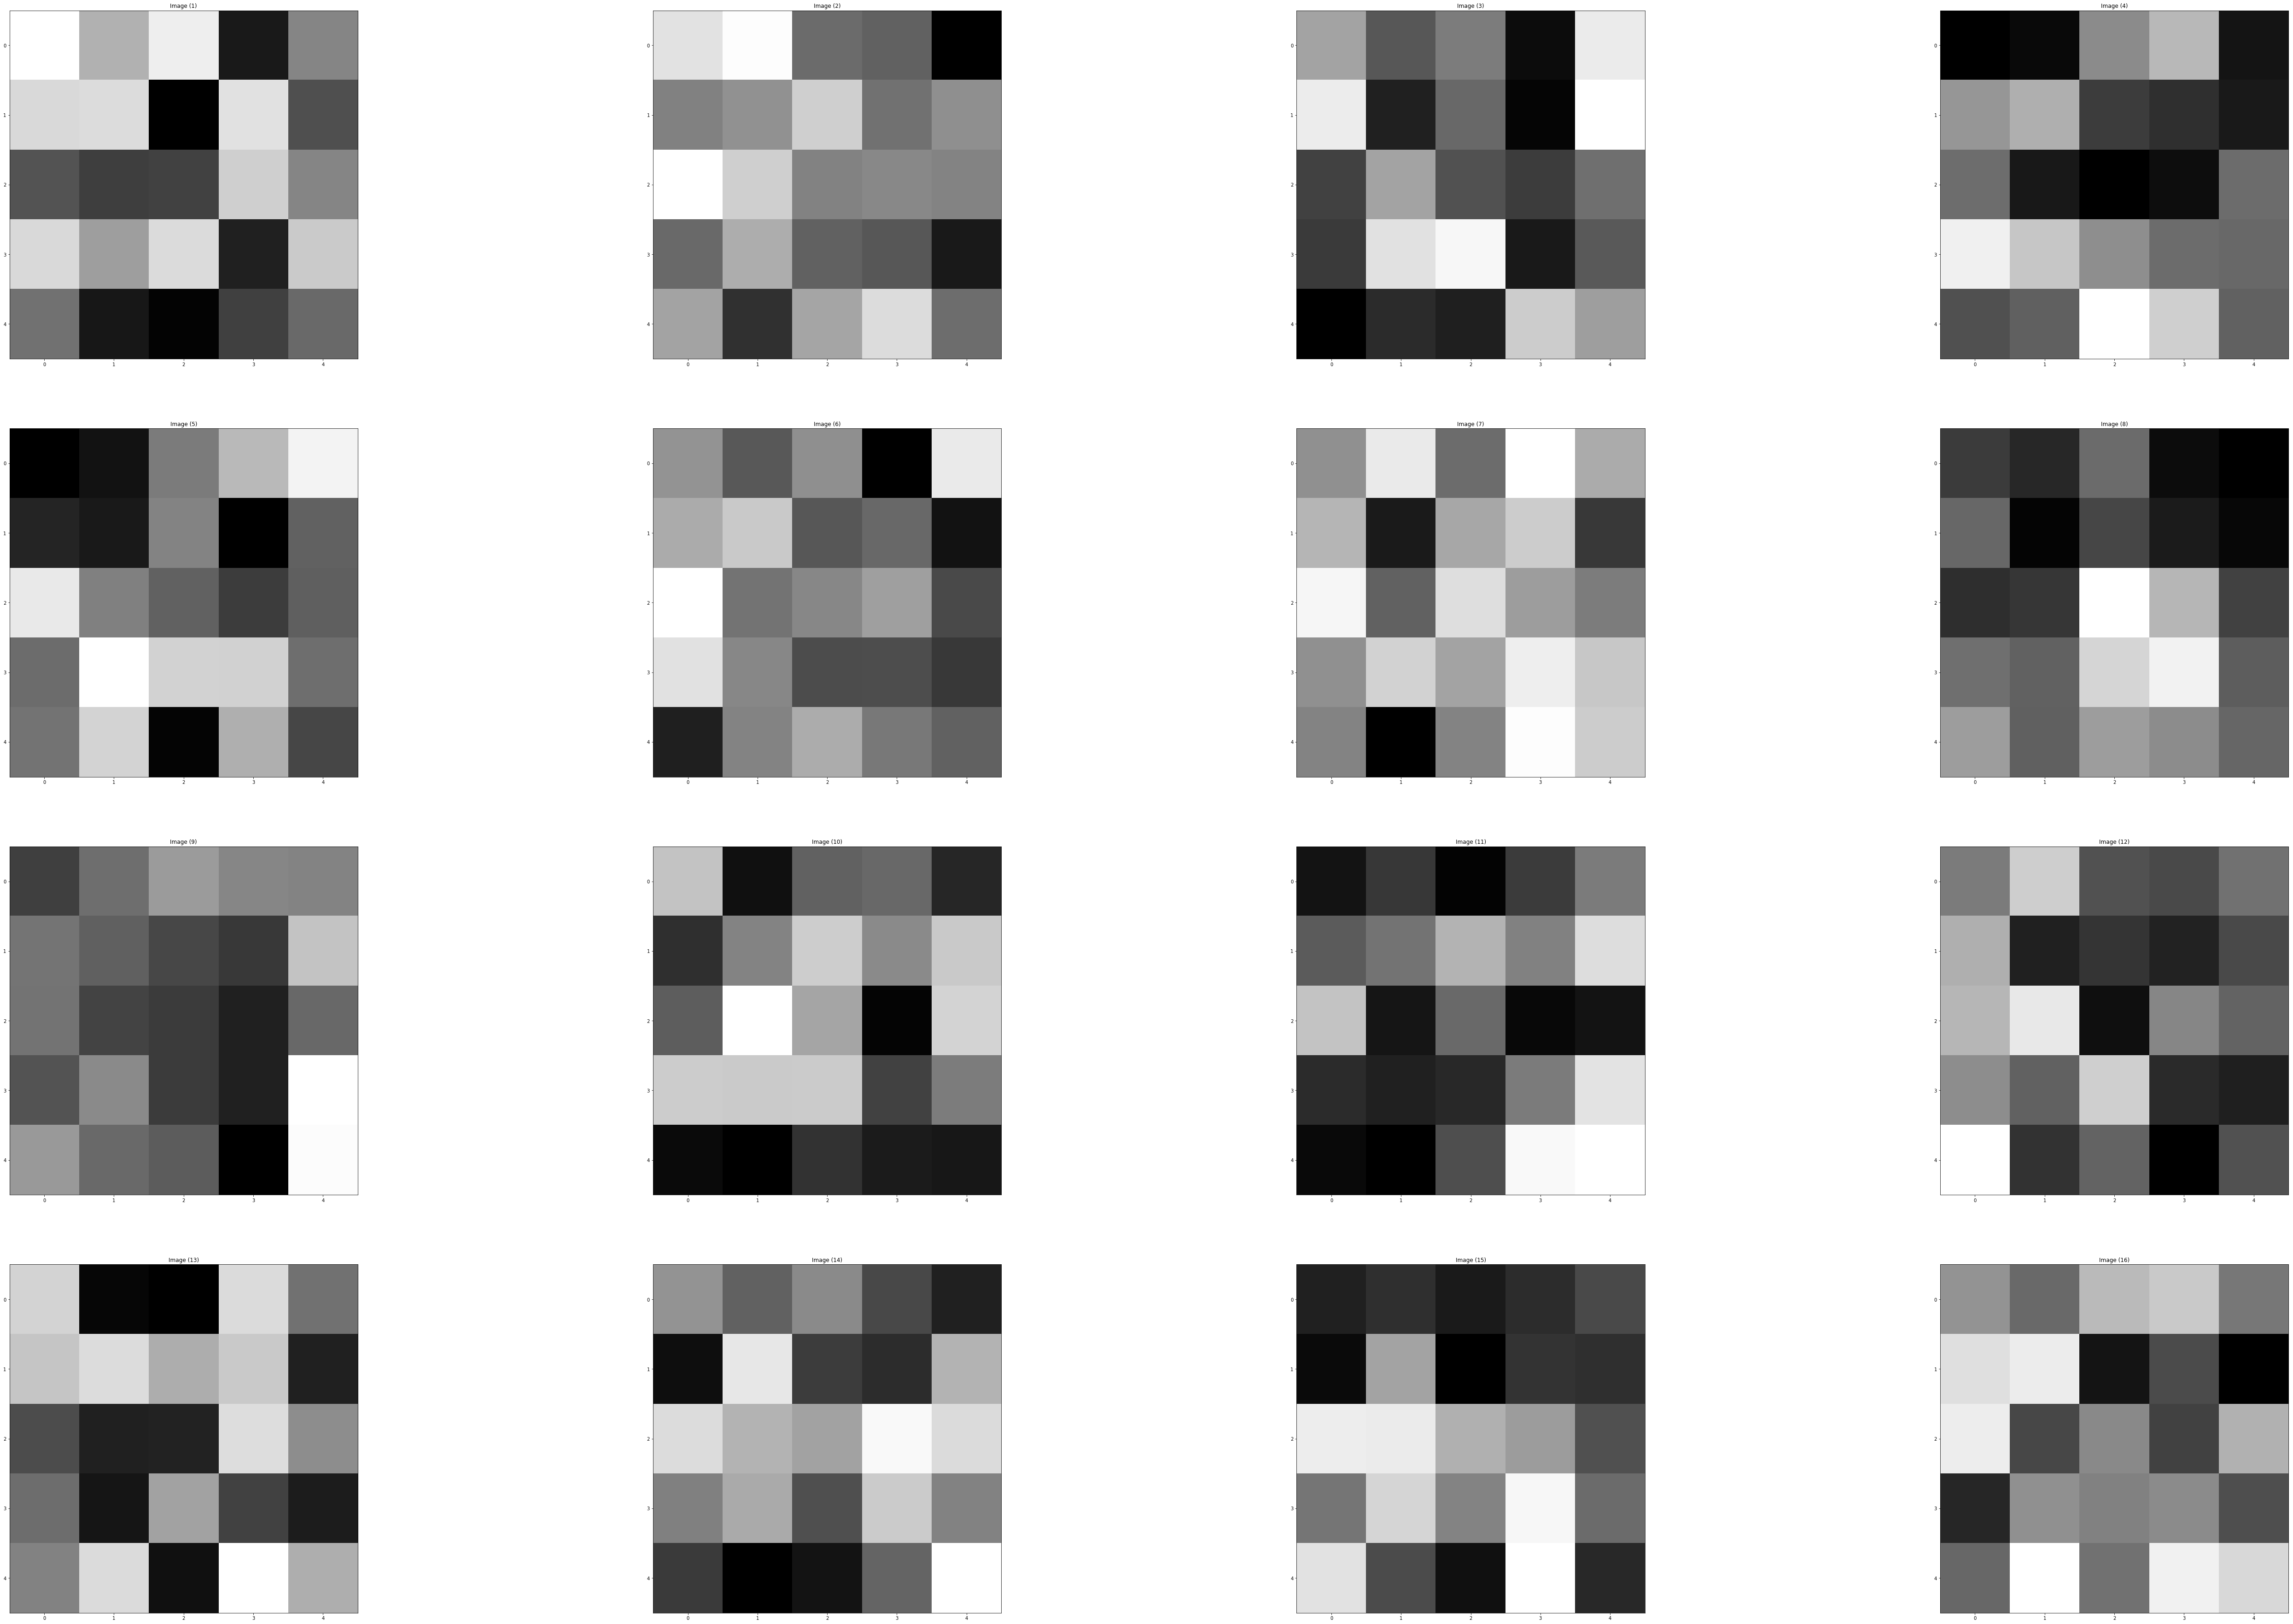

In [24]:
#Code adapted from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    rows
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
weights = tonumpy(model.first_layer.weight.data)
show_images([weight[0] for weight in weights], rows = 4)

## With a normal ML dataset we should see more reasonable learned features, I don't see the model learning much with our tiny training efforts though.